## Imports

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.ndimage import median_filter
from scipy import signal
from scipy.signal import convolve
from scipy.signal import correlate
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt

## Normal Distribution (PDF)

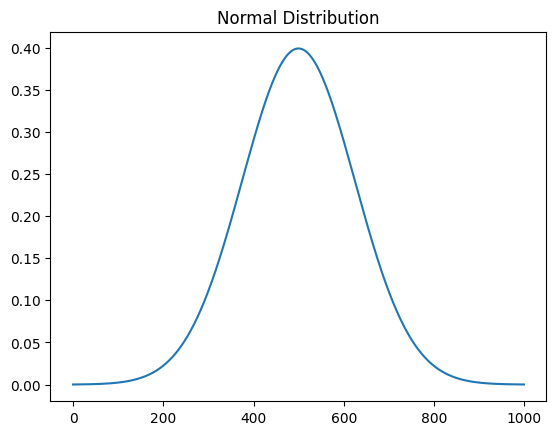

In [26]:
x = np.linspace(-4, 4, 1000)
pdf = norm.pdf(x, loc=0, scale=1)
plt.plot(pdf); plt.title('Normal Distribution')
plt.show()

## Gradient of Normal Distribution

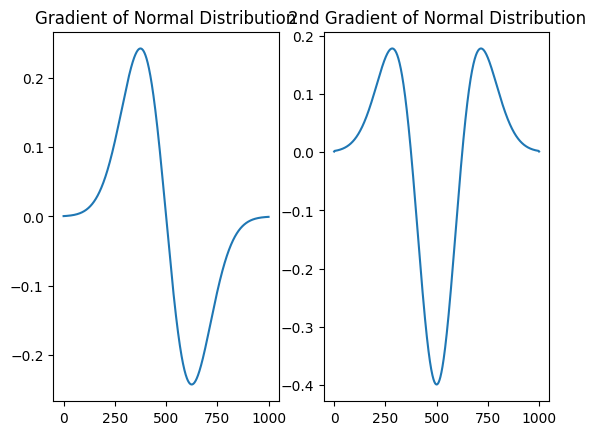

In [27]:
x = np.linspace(-4, 4, 1000)
pdf = norm.pdf(x, loc=0, scale=1)

pdf_prime_numerical = np.gradient(pdf, x)
pdf_double_prime_numerical = np.gradient(pdf_prime_numerical, x)

plt.subplot(121); plt.plot(pdf_prime_numerical); plt.title('Gradient of Normal Distribution')
plt.subplot(122); plt.plot(pdf_double_prime_numerical); plt.title('2nd Gradient of Normal Distribution')
plt.show()

## Generate Signal and Noise

In [28]:
def generate_signal(signal_type='sine', duration=2.0, fs=1000, **kwargs):
    """
    Generate clean signals.

    Args:
        signal_type: 'sine', 'chirp', 'square', 'sawtooth', 'custom'
        duration: Signal duration (seconds)
        fs: Sampling frequency (Hz)
        kwargs: Signal-specific params (e.g., freq, f0, f1)

    Returns:
        t (np.ndarray), clean_signal (np.ndarray)
    """
    t = np.linspace(0, duration, int(fs * duration), endpoint=False)

    if signal_type == 'sine':
        freq = kwargs.get('freq', 5)  # Hz
        clean = np.sin(2 * np.pi * freq * t)

    elif signal_type == 'chirp':
        f0, f1 = kwargs.get('f0', 1), kwargs.get('f1', 50)
        clean = signal.chirp(t, f0=f0, f1=f1, t1=duration, method='linear')

    elif signal_type == 'square':
        freq = kwargs.get('freq', 3)
        clean = signal.square(2 * np.pi * freq * t)

    elif signal_type == 'sawtooth':
        freq = kwargs.get('freq', 2)
        clean = signal.sawtooth(2 * np.pi * freq * t)

    elif signal_type == 'custom':
        # Example: sum of multiple sines
        clean = (
            0.5 * np.sin(2 * np.pi * 3 * t) +
            0.3 * np.sin(2 * np.pi * 7 * t + 1.2) +
            0.2 * np.sin(2 * np.pi * 12 * t - 0.8)
        )

    else:
        raise ValueError(f"Unknown signal_type: {signal_type}")

    return t, clean

In [29]:
def add_noise(clean, noise_type='gaussian', noise_amplitude=0.1, seed=None):
    """Add noise with fixed amplitude."""
    rng = np.random.default_rng(seed)

    if noise_type == 'gaussian':
        noise = rng.normal(0, noise_amplitude, clean.shape)
    elif noise_type == 'uniform':
        noise = rng.uniform(-noise_amplitude, noise_amplitude, clean.shape)
    elif noise_type == 'laplace':
        noise = rng.laplace(0, noise_amplitude / np.sqrt(2), clean.shape)  # Match variance
    else:
        raise ValueError(f"Unknown noise_type: {noise_type}")

    return clean + noise, noise

In [30]:
def add_noise_snr(clean, snr_db, noise_type='gaussian', seed=None):
    """
    Add noise to achieve exact target SNR (dB).

    Args:
        clean: Clean signal array
        snr_db: Target SNR in dB (e.g., 20 = clean, 0 = equal power, -10 = noisy)
        noise_type: 'gaussian', 'uniform', 'laplace'

    Returns:
        noisy_signal, noise
    """
    rng = np.random.default_rng(seed)

    # Calculate signal power (RMS)
    signal_power = np.mean(clean ** 2)

    # Convert SNR (dB) to linear scale
    snr_linear = 10 ** (snr_db / 10)

    # Required noise power
    noise_power = signal_power / snr_linear

    # Generate unit-power noise
    if noise_type == 'gaussian':
        noise = rng.normal(0, 1, clean.shape)
    elif noise_type == 'uniform':
        noise = rng.uniform(-np.sqrt(3), np.sqrt(3), clean.shape)  # Unit variance
    elif noise_type == 'laplace':
        noise = rng.laplace(0, 1 / np.sqrt(2), clean.shape)  # Unit variance
    else:
        raise ValueError(f"Unknown noise_type: {noise_type}")

    # Scale noise to target power
    noise = noise * np.sqrt(noise_power)

    return clean + noise, noise

Target SNR: 10 dB | Actual SNR: 10.09 dB


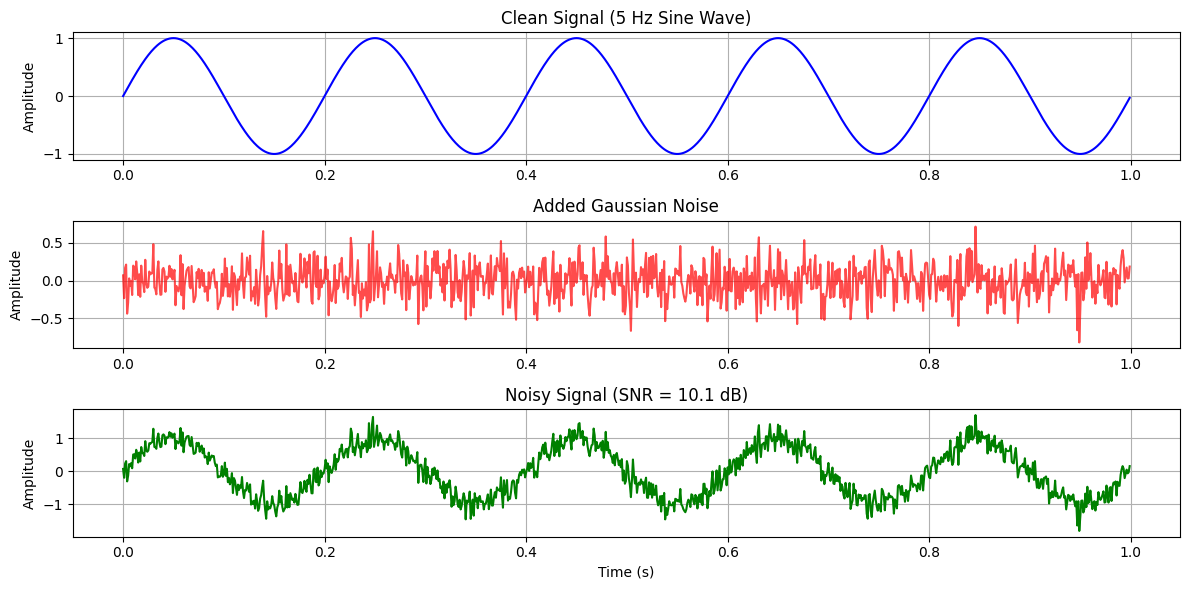

In [32]:
# Reproducibility
SEED = 42

# Generate clean signal
t, clean = generate_signal('sine', duration=1.0, fs=1000, freq=5)

# Add noise at 10 dB SNR
noisy, noise = add_noise_snr(clean, snr_db=10, noise_type='gaussian', seed=SEED)

# Verify actual SNR
actual_snr = 10 * np.log10(np.mean(clean**2) / np.mean(noise**2))
print(f"Target SNR: 10 dB | Actual SNR: {actual_snr:.2f} dB")

# Plot
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(t, clean, 'b', linewidth=1.5)
plt.title('Clean Signal (5 Hz Sine Wave)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t, noise, 'r', alpha=0.7)
plt.title('Added Gaussian Noise')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t, noisy, 'g', linewidth=1.2)
plt.title(f'Noisy Signal (SNR = {actual_snr:.1f} dB)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

## Denoise signals with Savgol and Median filters

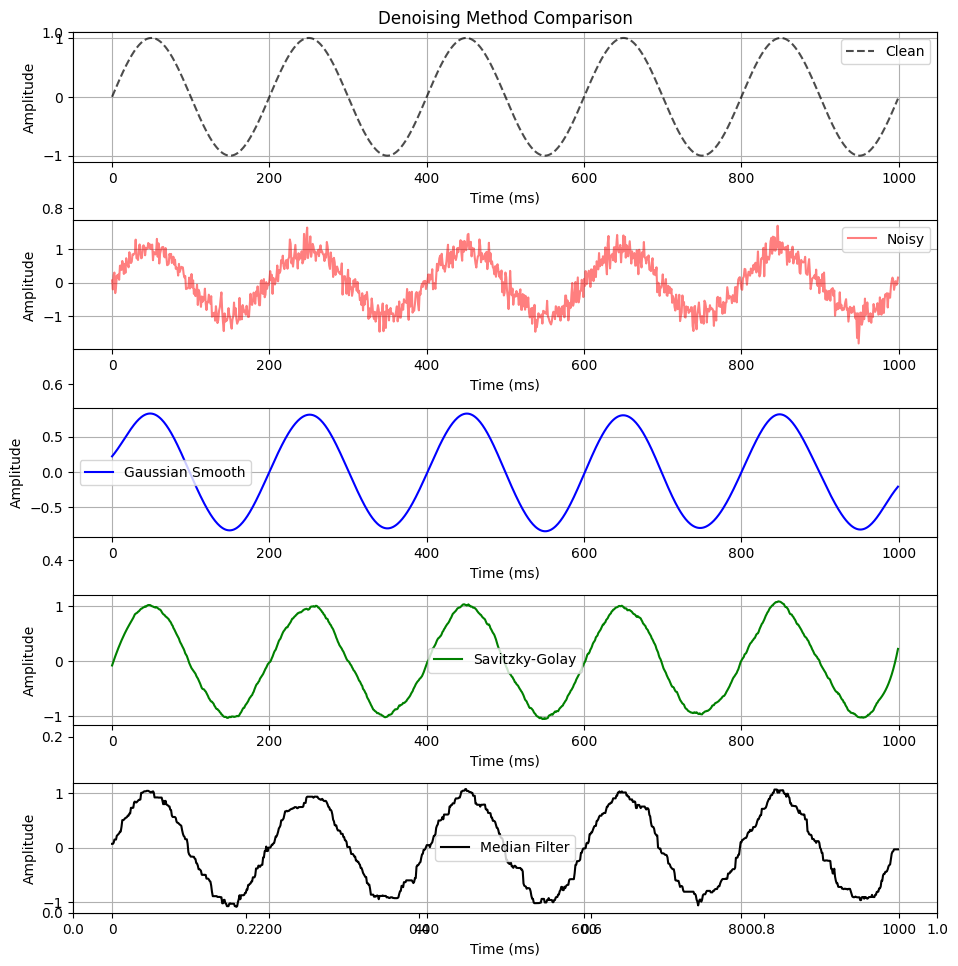

In [77]:
# Savitzky-Golay (preserves shape better)
denoised_sg = savgol_filter(noisy, window_length=51, polyorder=3)

# Median filter (for impulse noise)
denoised_med = median_filter(noisy, size=15)

# Plot comparison
plt.figure(figsize=(10, 10))
plt.title('Denoising Method Comparison')


plt.subplot(5, 1, 1); plt.plot(t*1000, clean, 'k--', label='Clean', alpha=0.7); plt.xlabel('Time (ms)'); plt.ylabel('Amplitude'); plt.legend(); plt.grid(True)
plt.subplot(5, 1, 2); plt.plot(t*1000, noisy, 'r', alpha=0.5, label='Noisy'); plt.xlabel('Time (ms)'); plt.ylabel('Amplitude'); plt.legend(); plt.grid(True)
plt.subplot(5, 1, 3); plt.plot(t*1000, denoised, 'b', label='Gaussian Smooth'); plt.xlabel('Time (ms)'); plt.ylabel('Amplitude'); plt.legend(); plt.grid(True)
plt.subplot(5, 1, 4); plt.plot(t*1000, denoised_sg, 'g', label='Savitzky-Golay'); plt.xlabel('Time (ms)'); plt.ylabel('Amplitude'); plt.legend(); plt.grid(True)
plt.subplot(5, 1, 5); plt.plot(t*1000, denoised_med, 'k', label='Median Filter'); plt.xlabel('Time (ms)'); plt.ylabel('Amplitude'); plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()

## Generate Band-Limit noise and Non-Stationary noise

In [ ]:
# 1. Band-limited noise (e.g., sensor noise with 100 Hz cutoff)
def bandlimited_noise(clean, fs, lowcut=0, highcut=100, snr_db=10, seed=None):
    rng = np.random.default_rng(seed)
    noise = rng.normal(0, 1, clean.shape)

    # Design Butterworth filter
    nyq = 0.5 * fs
    b, a = butter(4, [lowcut/nyq, highcut/nyq], btype='band')
    noise = filtfilt(b, a, noise)

    # Scale to target SNR
    signal_power = np.mean(clean**2)
    noise_power = np.mean(noise**2)
    noise = noise * np.sqrt(signal_power / (noise_power * 10**(snr_db/10)))
    return clean + noise

# 2. Non-stationary noise (e.g., noise amplitude increases over time)
def nonstationary_noise(clean, t, snr_start=20, snr_end=0, seed=None):
    rng = np.random.default_rng(seed)
    noise = rng.normal(0, 1, clean.shape)

    # Linear SNR decay
    snr_t = np.linspace(snr_start, snr_end, len(t))
    scaling = np.sqrt(np.mean(clean**2) / (10**(snr_t/10)))
    noise = noise * scaling

    return clean + noise

## Test type of noise

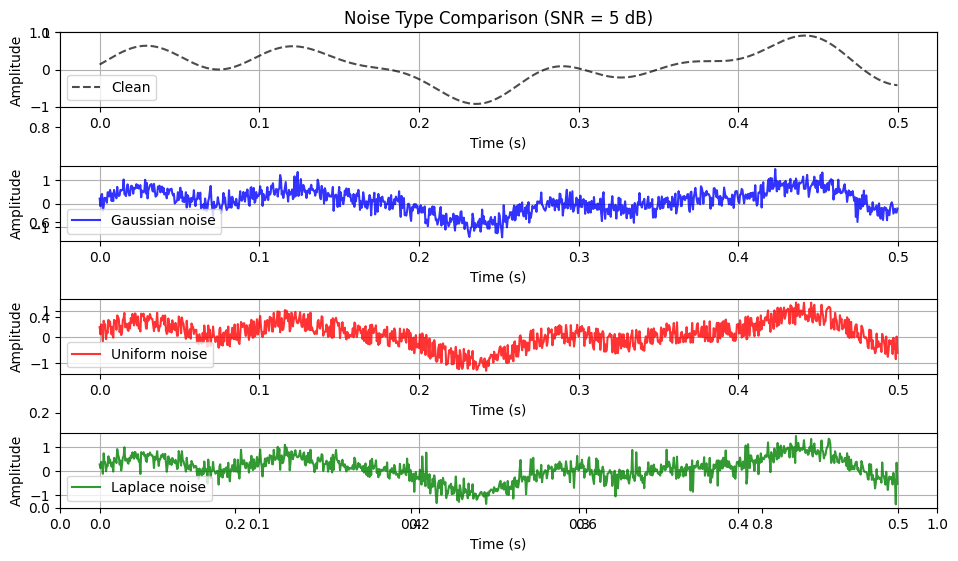

In [37]:
# Generate same clean signal
t, clean = generate_signal('custom', duration=0.5, fs=2000)

# Add different noise types at 5 dB SNR
noisy_gauss, _ = add_noise_snr(clean, snr_db=5, noise_type='gaussian', seed=SEED)
noisy_unif, _  = add_noise_snr(clean, snr_db=5, noise_type='uniform', seed=SEED)
noisy_lap, _   = add_noise_snr(clean, snr_db=5, noise_type='laplace', seed=SEED)

# Plot comparison
plt.figure(figsize=(10, 6))
plt.title('Noise Type Comparison (SNR = 5 dB)')

plt.subplot(411); plt.plot(t, clean, 'k--', label='Clean', alpha=0.7, linewidth=1.5);plt.xlabel('Time (s)');plt.ylabel('Amplitude'); plt.legend(); plt.grid(True)
plt.subplot(412); plt.plot(t, noisy_gauss, 'b', label='Gaussian noise', alpha=0.8);plt.xlabel('Time (s)');plt.ylabel('Amplitude'); plt.legend(); plt.grid(True)
plt.subplot(413); plt.plot(t, noisy_unif, 'r', label='Uniform noise', alpha=0.8);plt.xlabel('Time (s)');plt.ylabel('Amplitude'); plt.legend(); plt.grid(True)
plt.subplot(414); plt.plot(t, noisy_lap, 'g', label='Laplace noise', alpha=0.8);plt.xlabel('Time (s)');plt.ylabel('Amplitude'); plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()

## Compute SNR

In [43]:
# Quick SNR check function
def compute_snr(signal, noise):
    return 10 * np.log10(np.mean(signal**2) / np.mean(noise**2))

print(f"SNR: {compute_snr(clean, noisy - clean):.1f} dB")

SNR: -5.3 dB


## Denoise with applying custom Gaussian filter (**correlate**)

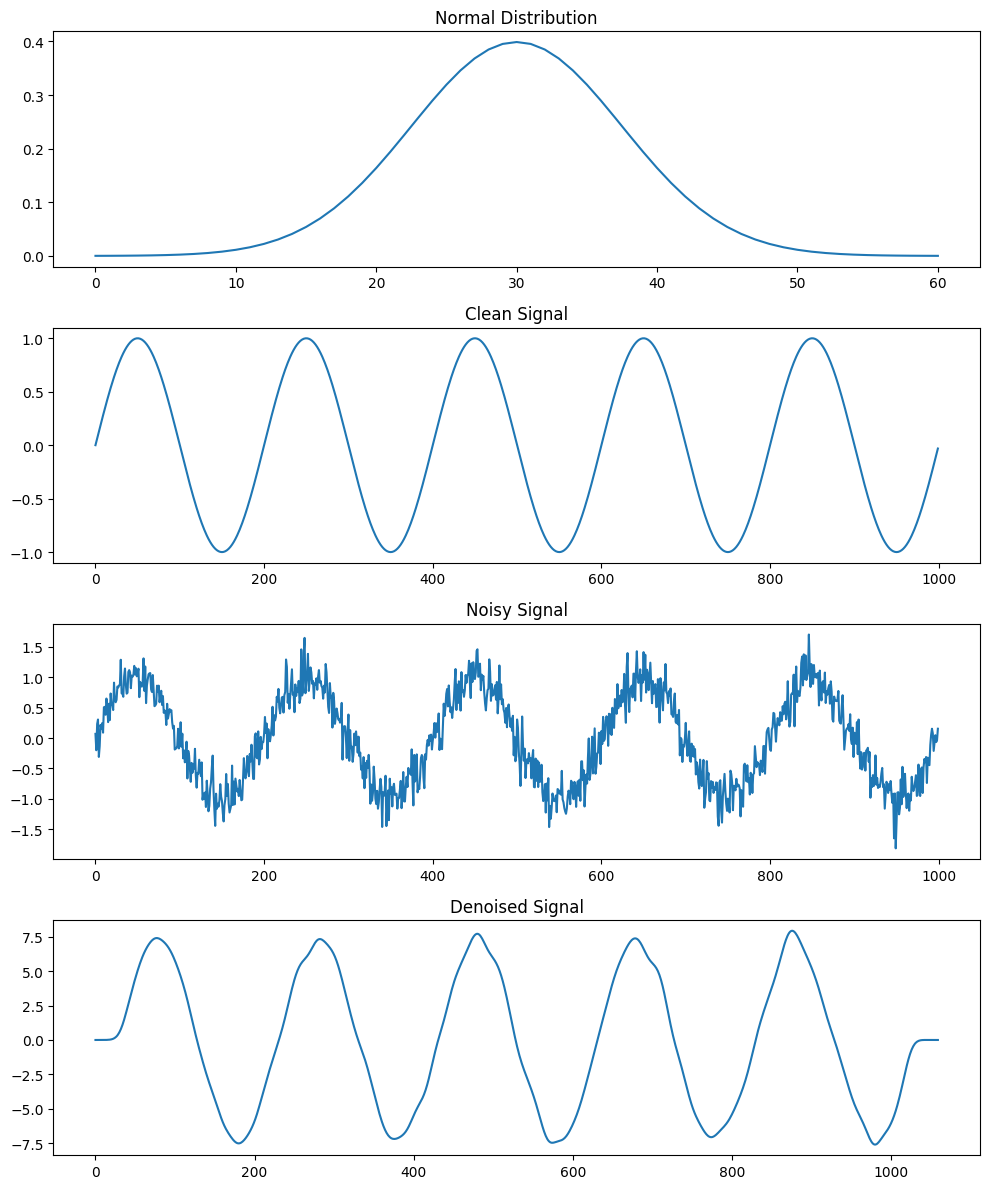

In [65]:
x = np.linspace(-4, 4, (2*30+1))
pdf = norm.pdf(x, loc=0, scale=1)

t, clean = generate_signal('sine', duration=1.0, fs=1000, freq=5)

# Add noise at 10 dB SNR
noisy, noise = add_noise_snr(clean, snr_db=10, noise_type='gaussian', seed=SEED)

denoised = correlate(noisy, pdf)
plt.figure(figsize=(10, 12))
plt.subplot(411); plt.plot(pdf); plt.title('Normal Distribution')
plt.subplot(412); plt.plot(clean); plt.title('Clean Signal')
plt.subplot(413); plt.plot(noisy); plt.title('Noisy Signal')
plt.subplot(414); plt.plot(denoised); plt.title('Denoised Signal')
plt.tight_layout()
plt.show()

## Denoise with applying Gaussian filter (**Convolution**)

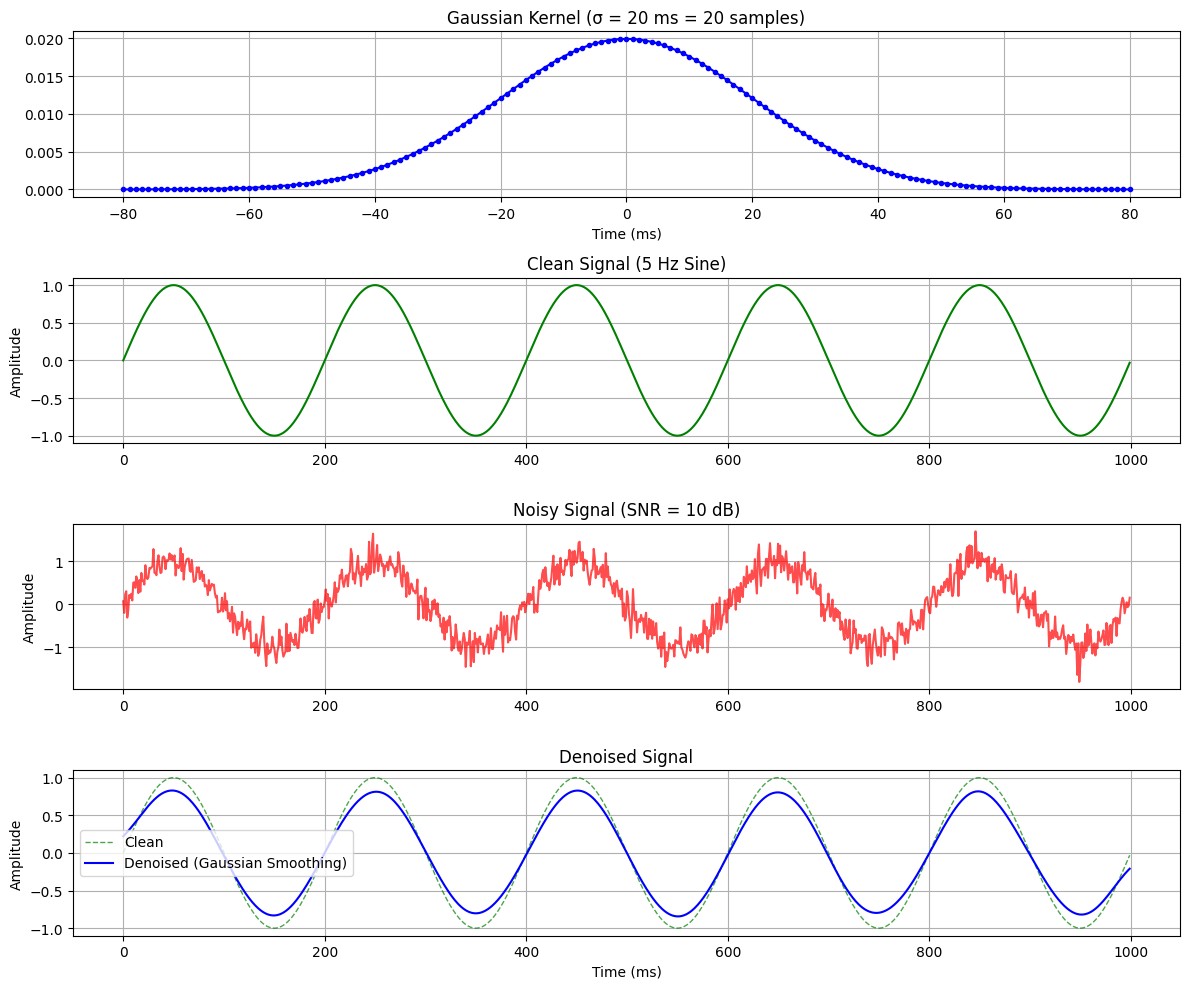

SNR before: 10.1 dB
SNR after : 14.5 dB
Improvement: 4.4 dB


In [66]:
# Reproducibility
SEED = 42
np.random.seed(SEED)

# Generate signal
t, clean = generate_signal('sine', duration=1.0, fs=1000, freq=5)
noisy, _ = add_noise_snr(clean, snr_db=10, noise_type='gaussian', seed=SEED)

# === CORRECT KERNEL DESIGN ===
fs = 1000  # Sampling frequency (Hz)
sigma_seconds = 0.02  # Desired smoothing width (e.g., 20 ms)
sigma_samples = sigma_seconds * fs  # Convert to samples

# Create Gaussian kernel centered in sample space
kernel_half_width = int(4 * sigma_samples)  # Cover ±4σ
kernel_x = np.arange(-kernel_half_width, kernel_half_width + 1)
gaussian_kernel = norm.pdf(kernel_x, loc=0, scale=sigma_samples)

# CRITICAL: Normalize kernel to preserve amplitude
gaussian_kernel /= np.sum(gaussian_kernel)

# === DENOISING VIA CONVOLUTION ===
denoised = convolve(noisy, gaussian_kernel, mode='same')  # 'same' preserves length

# === VISUALIZATION ===
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(kernel_x / fs * 1000, gaussian_kernel, 'b.-')
plt.title(f'Gaussian Kernel (σ = {sigma_seconds*1000:.0f} ms = {sigma_samples:.0f} samples)')
plt.xlabel('Time (ms)')
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(t*1000, clean, 'g', label='Clean', linewidth=1.5)
plt.title('Clean Signal (5 Hz Sine)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(t*1000, noisy, 'r', alpha=0.7, label='Noisy')
plt.title('Noisy Signal (SNR = 10 dB)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(t*1000, clean, 'g--', label='Clean', alpha=0.7, linewidth=1)
plt.plot(t*1000, denoised, 'b', label='Denoised (Gaussian Smoothing)', linewidth=1.5)
plt.title('Denoised Signal')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# === QUANTIFY IMPROVEMENT ===
snr_before = 10 * np.log10(np.mean(clean**2) / np.mean((noisy-clean)**2))
snr_after = 10 * np.log10(np.mean(clean**2) / np.mean((denoised-clean)**2))
print(f"SNR before: {snr_before:.1f} dB")
print(f"SNR after : {snr_after:.1f} dB")
print(f"Improvement: {snr_after - snr_before:.1f} dB")